In [1]:
%load_ext autoreload
%autoreload 2

# Analysis of hyperparameter search v2
The purpose of this notebook is to understand if the trained CT-RNNs can generalize to `trial_lengths` outside of its distribution.

## Imports

In [2]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import jax.numpy as jnp
from jax import random
from flax import linen as nn
from modularRNN.model import CTRNNCell
from modularRNN.task import ModularArithmeticTask
from modularRNN.training import create_train_state, ModelParameters

from sklearn.decomposition import PCA

from functools import partial

## Analysis

In [3]:
job_folder = "../../data/hyperparameter_2"
search_results = []

for task_id in range(384):
    try:
        metrics_loc = os.path.join(job_folder, f"task_{task_id}/metrics_history.csv")
        test_loss_min = pd.read_csv(metrics_loc)['test_loss'].min()
        test_acc_max = pd.read_csv(metrics_loc)['test_accuracy'].max()
        long_loss_min = pd.read_csv(metrics_loc)['long_loss'].min()
        long_acc_max = pd.read_csv(metrics_loc)['long_accuracy'].max()

        var_explained_loc = os.path.join(job_folder, f"task_{task_id}/cumulative_variance.npy")
        var_exp_arr = jnp.load(var_explained_loc)
        
        params_loc = os.path.join(job_folder, f"task_{task_id}/params.json")
        with open(params_loc, 'r') as f:
            json_params = json.load(f)
        
        seed = json_params.get('seed', 0)
        alpha = json_params.get('alpha', 0.1)
        noise = json_params.get('noise', 0.05)
        pulse_mean = json_params.get('pulse_mean', 8)
        mod_set = json_params.get('mod_set', [5,])
        mod_value_list = len(mod_set)
        training_trials = json_params.get('training_trials', 3200)
        train_batch_size = json_params.get('train_batch_size', 128)
        testing_trials = json_params.get('testing_trials', 320)
        lr = json_params.get('lr', 0.001)
        epochs = json_params.get('epochs', 500)
        weight_decay = json_params.get('weight_decay', 0.0001)
        l2_penalty = json_params.get('l2_penalty', 0.0001)

        task_stats_params = {
            'test_loss_min': test_loss_min,
            'test_acc_max': test_acc_max,
            'long_loss_min': long_loss_min,
            'long_acc_max': long_acc_max,
            'cum_var': var_exp_arr[2].item(),
            'seed': seed,
            'alpha': alpha,
            'noise': noise,
            'pulse_mean': pulse_mean,
            'mod_set': mod_set,
            'mod_value_list': mod_value_list,
            'training_trials': training_trials,
            'train_batch_size': train_batch_size,
            'testing_trials': testing_trials,
            'lr': lr,
            'epochs': epochs,
            'weight_decay': weight_decay,
            'l2_penalty': l2_penalty,
        }
        search_results.append(task_stats_params)

    except FileNotFoundError:
        continue

In [4]:
df_search_results = pd.DataFrame(search_results)
df_search_results.sort_values('long_loss_min', ascending=True).head(25)

,test_loss_min,test_acc_max,long_loss_min,long_acc_max,cum_var,seed,alpha,noise,pulse_mean,mod_set,mod_value_list,training_trials,train_batch_size,testing_trials,lr,epochs,weight_decay,l2_penalty
0,0.000035,1.0,0.000027,1.0,0.726695,207,0.1,0.05,12,[3],1,6400,128,640,0.01,1500,0.001,0.0001


## Analyze seed 207

In [5]:
task_id = 'task_207'

params_for_json = f"../../data/hyperparameter_2/{task_id}/params.json"
example_csv = f"../../data/hyperparameter_2/{task_id}/metrics_history.csv"
model_params_save = f"../../data/hyperparameter_2/{task_id}/test_params.bin"

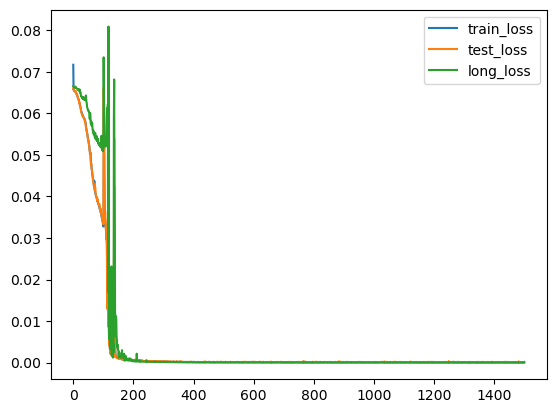

In [6]:
df_metrics = pd.read_csv(example_csv)

plt.plot(df_metrics['train_loss'], label='train_loss')
plt.plot(df_metrics['test_loss'], label='test_loss')
plt.plot(df_metrics['long_loss'], label='long_loss')
plt.legend()
plt.show()

In [7]:
with open(params_for_json, 'r') as f:
    json_params = json.load(f)

seed = json_params.get('seed', 0)
alpha = json_params.get('alpha', 0.1)
noise = json_params.get('noise', 0.05)
pulse_mean = json_params.get('pulse_mean', 12)
mod_set = json_params.get('mod_set', [5,])
training_trials = json_params.get('training_trials', 3200)
testing_trials = json_params.get('testing_trials', 640)
train_batch_size = json_params.get('train_batch_size', 128)
lr = json_params.get('lr', 0.001)
epochs = json_params.get('epochs', 500)
weight_decay = json_params.get('weight_decay', 0.0001)
l2_penalty = json_params.get('l2_penalty', 0.0001)
trial_length = json_params.get('trial_length', 100)

key = random.PRNGKey(seed)

In [8]:
mod_set = jnp.array(mod_set)
pulse_distribution = partial(random.poisson, lam=pulse_mean)

key, subkey = random.split(key)
modtask = ModularArithmeticTask(
    subkey, 
    training_trials, 
    testing_trials, 
    train_batch_size, 
    mod_set, 
    pulse_distribution, 
    trial_length,
)
training_dataset, testing_dataset = modtask.tf_datasets()

100%|███████████████████████████████████████████████████████████████████████████████| 640/640 [00:00<00:00, 891.29it/s]


In [9]:
key, subkey = random.split(key)
modtask_long = ModularArithmeticTask(
    subkey, 
    640, 
    640, 
    640, 
    mod_set, 
    partial(random.poisson, lam=2*pulse_mean), 
    500,
)
_, testing_dataset_long = modtask_long.tf_datasets()

100%|███████████████████████████████████████████████████████████████████████████████| 640/640 [00:01<00:00, 409.32it/s]


In [10]:
features = 100
alpha = jnp.float32(alpha)
noise = jnp.float32(noise)

ctrnn = nn.RNN(CTRNNCell(features=features, alpha=alpha, noise=noise, out_shape=10,))

key, subkey = random.split(key)
state = create_train_state(ctrnn, subkey, lr, weight_decay, trial_length)

In [11]:
model_params = ModelParameters(state)
model_params.deserialize(model_params_save,)

In [12]:
for _inputs, _outputs in testing_dataset.as_numpy_iterator():
    pass
    
key, subkey = random.split(key)
z_0, rates_0 = ctrnn.apply(model_params.params, _inputs, init_key=subkey,)

2024-04-06 14:31:05.902183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


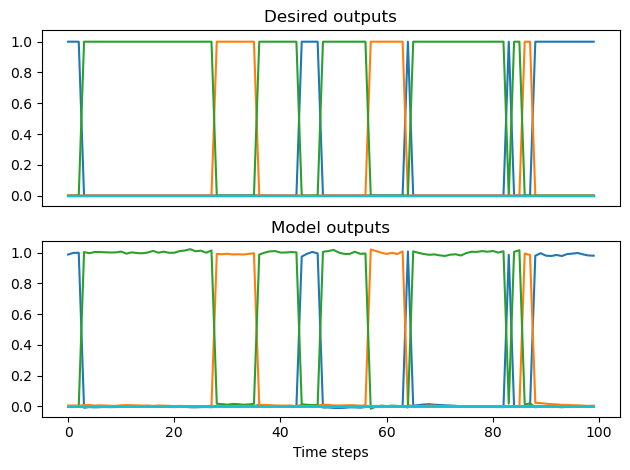

In [13]:
fig, axs = plt.subplots(2, 1, sharey=True)

axs[0].plot(_outputs[0,:,:])
axs[0].set_title('Desired outputs')
axs[0].set_xticks([])
axs[1].plot(z_0[0,:,:])
axs[1].set_title('Model outputs')
axs[1].set_xlabel('Time steps')
plt.tight_layout()
plt.show()

In [14]:
for _inputs, _outputs in testing_dataset_long.as_numpy_iterator():
    pass
    
key, subkey = random.split(key)
z_0, rates_0 = ctrnn.apply(model_params.params, _inputs, init_key=subkey,)

2024-04-06 14:31:06.807335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


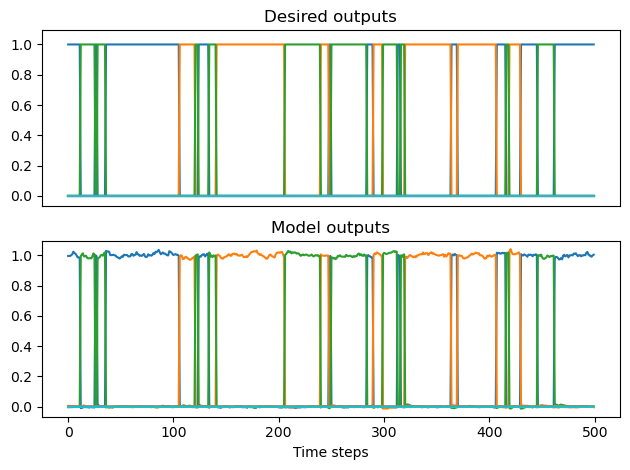

In [15]:
fig, axs = plt.subplots(2, 1, sharey=True)

axs[0].plot(_outputs[0,:,:])
axs[0].set_title('Desired outputs')
axs[0].set_xticks([])
axs[1].plot(z_0[0,:,:])
axs[1].set_title('Model outputs')
axs[1].set_xlabel('Time steps')
plt.tight_layout()
plt.show()

## PCA 

In [16]:
rates_list = []

for _inputs, _outputs in tqdm(training_dataset.as_numpy_iterator()):
    key, subkey = random.split(key)
    _, _rates = ctrnn.apply(model_params.params, _inputs, init_key=subkey,)
    rates_list.append(_rates)

50it [00:09,  5.40it/s]2024-04-06 14:31:16.845620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



In [17]:
rates_ = jnp.concatenate(rates_list, axis=0)
rates_shape = rates_.shape
rates_shape

(6400, 100, 100)

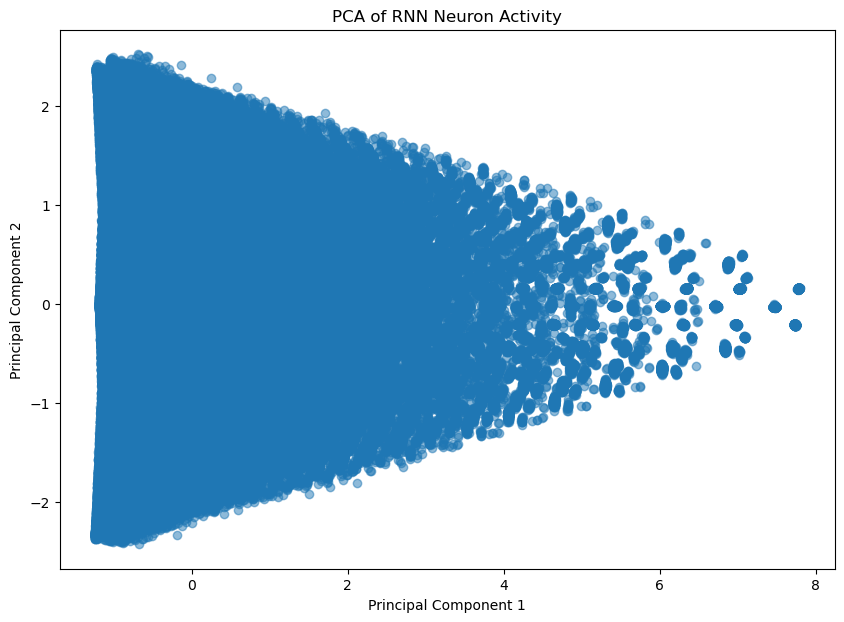

In [18]:
rates_reshaped = rates_.reshape(-1, rates_.shape[-1])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(rates_reshaped)

plt.figure(figsize=(10, 7))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of RNN Neuron Activity')
plt.show()

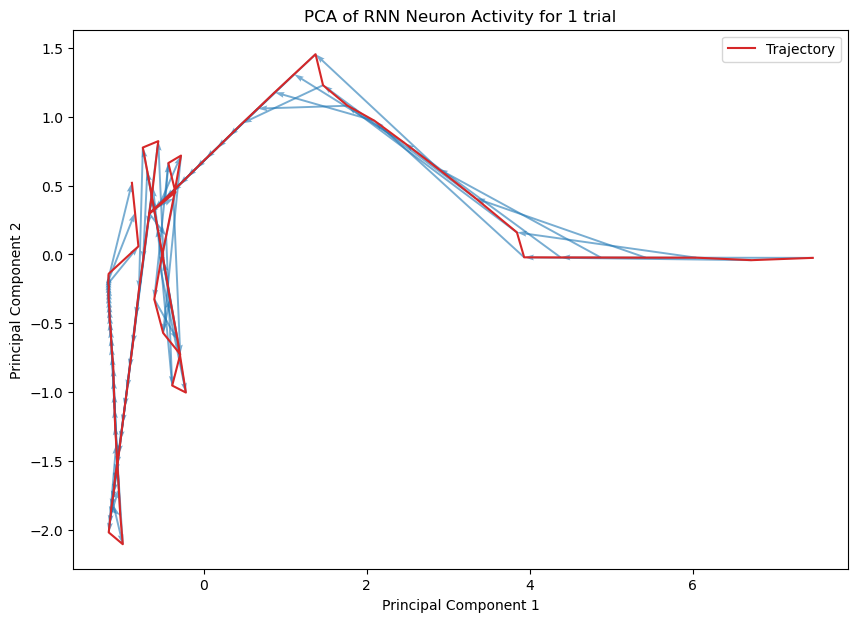

In [19]:
reshaped_pc = principal_components.reshape(rates_shape[0], rates_shape[1], 2)
x = reshaped_pc[0, :, 0]
y = reshaped_pc[0, :, 1]

plt.figure(figsize=(10, 7))
plt.plot(x, y, color='tab:red', label='Trajectory')

skip = 5
X, Y = x[:-skip], y[:-skip]
U, V = x[skip:] - x[:-skip], y[skip:] - y[:-skip]

plt.quiver(X, Y, U, V, scale_units='xy', angles='xy', scale=1, color='tab:blue', width=0.0025, alpha=0.6)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of RNN Neuron Activity for 1 trial')
plt.legend()
plt.show()